# Exploratory Data Analysis of IMDb Movies

![](http://www.remilindenhovius.com/wp-content/uploads/2013/09/IMDB.jpg)

**Introduction:** The Internet Movie Database (IMDb) is an online database of movies, TV series, home video, video games, among others. It also holds information on these entries, such as title, year made, language, cast, directors, and reviews. In this analysis, I will be concentrating my efforts on movies and will attempt to gain some insight into their production and reception.

We'll begin by importing and cleaning our data. Then by taking peeks at the dataset, we'll come up with interesting questions to answer using different data visualization techniques. This will give us an idea of what movies are successful, why certain runtimes are preferable to others, and how viewer preferences have changed over time.

In [35]:
import jovian
jovian.commit(filename='IMDBProject2.ipynb')

<IPython.core.display.Javascript object>

[jovian] Updating notebook "freakflak/imdbproject2" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/freakflak/imdbproject2


'https://jovian.ai/freakflak/imdbproject2'

# Import all necessary libraries

In [36]:
!pip install numpy pandas==1.1.5 jovian opendatasets seaborn matplotlib plotly --upgrade --quiet;

In [37]:
import pandas as pd
import numpy as np
import opendatasets as od
import plotly.express as px
import seaborn as sns
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from functools import reduce
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Data Import and Cleaning

We'll analyze data from IMDb's movie database. Some of their data is missing, so a it will need to be dealt with. We will also focus on movies in order to explore and visualize relationships between variables.

With the data imported and cleaned up, our visualizations will give us clues about what makes a movie more than good!

The dataset we'll be using is pulled from Kaggle, where it was compiled from IMDb's release of their very own data. We'll use opendata's "download_kaggle_dataset" to download to our local directory.

In [38]:
dataset_url = 'https://www.kaggle.com/datasets/kunwarakash/imdbdatasets'
od.download_kaggle_dataset(dataset_url,'.')

Skipping, found downloaded files in "./imdbdatasets" (use force=True to force download)


Listing the folder "imdbdatasets" we see there are 7 files which are all tab separated. We'll only be using three of these datasets in order to focus on the movies themselves, which are: `akas.tsv`, `ratings.tsv`,  `basics.tsv`.

In [39]:
os.listdir('imdbdatasets')

['title_basics.tsv',
 'title_ratings.tsv',
 'title_crew.tsv',
 'name_basics.tsv',
 'title_akas.tsv',
 'title_episode.tsv',
 'title_principals.tsv']

### Reading Tab-Separated Value (TSV) Datasets

In order to read tab separated files, we'll use the "sep" argument in read_csv. In this instance we will also change the name of the column from `titleId` to `tconst`, which is the unique key given to all titles, and the column name used in both `ratings` and `basics` data files. The akas file contains data such as the foreign key, title, region, attributes and if it is the original title.

In [40]:
akas_df = pd.read_csv("imdbdatasets/title_akas.tsv", sep='\t', low_memory = False)
akas_df.rename(columns={'titleId': 'tconst'},
          inplace=True, errors='raise')
akas_df.shape

(31803571, 8)

We'll only take the value of original title if it equals true. This will greatly reduce the amount of titles to analyse, while not ignoring any.

In [41]:
akas_df = akas_df.loc[akas_df['isOriginalTitle'] == 1]
akas_df

,tconst,ordering,title,region,language,types,attributes,isOriginalTitle


The ratings file includes a foreign key, the average rating and the number of votes for each title.

In [42]:
ratings_df = pd.read_csv("imdbdatasets/title_ratings.tsv", sep='\t')
ratings_df

,tconst,averageRating,numVotes
0,tt0000001,5.7,1876
1,tt0000002,5.9,248
2,tt0000003,6.5,1648
3,tt0000004,5.8,160
4,tt0000005,6.2,2475
...,...,...,...
1239447,tt9916690,6.5,6
1239448,tt9916720,5.1,209
1239449,tt9916730,8.7,6
1239450,tt9916766,6.7,19


The basics file includes a foreign key, type of title, primary title, original title, adult flag, start year (or release year), end year (if it is a series), run time, and genres. Since we're only focusing on movies, we'll set the `titleType` to be equal to `movie`.

In [43]:
basics_df = pd.read_csv("imdbdatasets/title_basics.tsv", sep='\t', low_memory=False)
basics_df = basics_df.loc[basics_df['titleType'] == 'movie']
basics_df


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama
625,tt0000630,movie,Hamlet,Amleto,0,1908,\N,\N,Drama
...,...,...,...,...,...,...,...,...,...
8880091,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,\N,57,Documentary
8880118,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,\N,100,Documentary
8880130,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,\N,Comedy
8880141,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,\N


To make analysis easier, we'll merge all three data frames based on their `tconst` keys and drop the `tconst` column since we will not need it anymore. We will also drop the `endYear` column since we are only considering movies, which do not have an end year as they are not series.

In [44]:
data_frames = [basics_df,  ratings_df, akas_df]
merged_df = reduce(lambda  left,right: pd.merge(left, right, on=['tconst'],how='left'), data_frames)
merged_df.drop(['tconst', 'endYear'], axis = 1, inplace = True)
merged_df

,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,ordering,title,region,language,types,attributes,isOriginalTitle
0,movie,Bohemios,Bohemios,0,1905,100,\N,4.5,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,70,"Action,Adventure,Biography",6.0,760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,movie,The Prodigal Son,L'enfant prodigue,0,1907,90,Drama,4.6,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,Drama,4.5,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,movie,Hamlet,Amleto,0,1908,\N,Drama,3.8,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608535,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,57,Documentary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608536,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,100,Documentary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608537,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608538,movie,6 Gunn,6 Gunn,0,2017,116,\N,8.7,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dealing with Missing Data

Now, let's take a glance at our columns. We can see that the `dtype` is incorrect for some of the columns which should be numeric. Such as `isAdult`, `startYear`, and `runtimeMinutes`. Before we can convert these to float columns, we'll need to deal with the non-applicable values of `\N` which they have chosen for this dataset. We'll replace all instances of `\N` with `np.nan`, which is valid for both str and numeric types.

In [45]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608540 entries, 0 to 608539
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   titleType        608540 non-null  object 
 1   primaryTitle     608540 non-null  object 
 2   originalTitle    608540 non-null  object 
 3   isAdult          608540 non-null  object 
 4   startYear        608540 non-null  object 
 5   runtimeMinutes   608540 non-null  object 
 6   genres           608540 non-null  object 
 7   averageRating    277664 non-null  float64
 8   numVotes         277664 non-null  float64
 9   ordering         0 non-null       float64
 10  title            0 non-null       object 
 11  region           0 non-null       object 
 12  language         0 non-null       object 
 13  types            0 non-null       object 
 14  attributes       0 non-null       object 
 15  isOriginalTitle  0 non-null       object 
dtypes: float64(3), object(13)
memory usage

In [46]:
merged_df.replace(to_replace='\\N', value = np.nan, inplace= True)
merged_df[['isAdult', 'startYear','runtimeMinutes']] = merged_df[['isAdult', 'startYear','runtimeMinutes']].astype('float64', copy = False)
merged_df

,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,ordering,title,region,language,types,attributes,isOriginalTitle
0,movie,Bohemios,Bohemios,0.0,1905.0,100.0,NaN,4.5,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70.0,"Action,Adventure,Biography",6.0,760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90.0,Drama,4.6,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,movie,Robbery Under Arms,Robbery Under Arms,0.0,1907.0,NaN,Drama,4.5,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,movie,Hamlet,Amleto,0.0,1908.0,NaN,Drama,3.8,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608535,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0.0,2015.0,57.0,Documentary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608536,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0.0,2007.0,100.0,Documentary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608537,movie,Dankyavar Danka,Dankyavar Danka,0.0,2013.0,NaN,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608538,movie,6 Gunn,6 Gunn,0.0,2017.0,116.0,NaN,8.7,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Taking a quick look at the runtime in descinding order, we can see that there are a few outliers that will skew future analysis. We can leave these here for now, and filter them out when using runtime. The longest movie is `Logistics`, coming in at 51 thousand minutes. Known as the longest film ever made, it follows the path from the sale of a pedometer all the way back to its manufacture in Shenzhen.

In [47]:
merged_df.sort_values(by='runtimeMinutes', ascending =False)

,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,ordering,title,region,language,types,attributes,isOriginalTitle
577920,movie,Logistics,Logistics,0.0,2012.0,51420.0,Documentary,6.2,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466113,movie,Ambiancé,Ambiancé,0.0,2020.0,43200.0,Documentary,5.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278938,movie,Carnets Filmés (Liste Complète),Carnets Filmés (Liste Complète),0.0,2019.0,28643.0,Documentary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428485,movie,Modern Times Forever,Modern Times Forever,0.0,2011.0,14400.0,Documentary,6.4,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247455,movie,Qw,Qw,0.0,2019.0,10062.0,Drama,7.5,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608526,movie,Yesterday's Dreams,Yesterday's Dreams,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608528,movie,Minotaur,Minotaur,0.0,NaN,NaN,Thriller,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608532,movie,The Secret of China,Hong xing zhao yao Zhong guo,0.0,2019.0,NaN,"Adventure,History,War",3.6,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608534,movie,The Copeland Case,The Copeland Case,0.0,NaN,NaN,Drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Questions and Answers with Analysis

## 1. How has the amount of movies released over time changed?

Let's take `merged_df` and consider all movies with a valid release year before 2023 since most movies have not yet been released or announced. We group all movies by their start year and count the number of occurences.

In [48]:
fig = px.line((merged_df.loc[(merged_df['startYear'] != np.nan) & (merged_df['startYear'] < 2023)]).groupby('startYear').count(),
        y = 'titleType')
fig.update_layout(title = 'Number of Movies Produced Vs. Release Year', xaxis_title = 'Release Year', yaxis_title='Number of Movies Produced')

Using a line graph, we can clearly see that the amount of movies has been generally growing over time. There are a couple major noticable changes as we can see. Most notably, the amount of movies produced dipped significantly during the second world war (1939-1945), and during the covid-19 pandemic.

## 2. What are the most popular genres of movies?

The genres column in our dataset can be comprised of several genres separated by a comma. In order to look at their frequency, we'll split each genre row into new columns and count up the occurrences. Plotting this result, we see that `Drama` is by far the most popular.

In [49]:
genres_df = merged_df['genres'].str.split(',', expand = True)
genres_count = pd.DataFrame(pd.Series(genres_df.squeeze().values.ravel()).value_counts())
genres_count.rename(columns = {0:'Genre'}, inplace = True)
fig = px.bar(genres_count)
fig.update_layout(title = 'Overall Count per Genre', xaxis_title = 'Genre Type', yaxis_title='Number of Genres', showlegend = False)

Dramas may be the most common as most movies involve a dramatic reenactment of a story. Therefore, most movies will also be classified under Drama. Documentaries come as second most popular, which may sound a bit surprising. However, most reality shows and movies will also fall under the documentary tag. For instance, even Jackass is classified under documentaries. If that's possible, then I should think almost anything could be classified as a documentary.

## 3. What does the distribution of runtimes look like?

We'll exlude all runtimes which are not valid, and those that are longer than 300 minutes since they are the exception. We'll use a logarithmic y-axis in order to better see the changes in the number of movies produced.

In [50]:
runtime_df = merged_df.loc[(merged_df['runtimeMinutes'] != np.nan) & (merged_df['runtimeMinutes'] < 300)]
fig = px.histogram(runtime_df, x = runtime_df['runtimeMinutes'], log_y = True)
fig.update_layout(title = 'Number of Movies Produced Vs. Running Time', xaxis_title = 'Runtime', yaxis_title='Number of Movies Produced')

By graphing using a histogram, we can see a definite trend. What we can see is that there is a large jump at 45 minutes, and that the maximum amount of films is twice that at 90 minutes. This is likely due to the ability to show the film on TV and include 15 minute long commercials per hour. After 90 minutes, it steadily declines.

## 4. Which columns have the greatest correlation?

We can use Seaborn to plot a heatmap and visualize the correlation different columns have on each other. By using Pandas' `difference` function, we can exclude certain columns from our consideration. Then, plotting the correlation given by Pandas' `corr` function, we can see where some correlations may occur.

<AxesSubplot:>

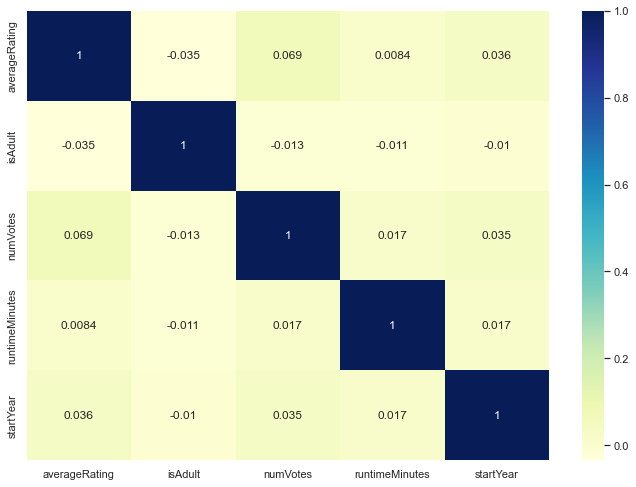

In [51]:
sns.heatmap(merged_df[merged_df.columns.difference(['isOriginalTitle','level_0','index','ordering','language','attributes','region','title','types'])]
.corr(), cmap='YlGnBu', annot=True)

As you can see, the strongest correlation here is the one between the number of votes and the average rating. The greater the number of votes, the more likely the greater the average rating.

Below, we'll visualize some of these correlations.

## How does the number of votes visualize against the average rating?

[Text(0.5, 0, 'Average Rating'),
 Text(0, 0.5, 'Number of Votes'),
 Text(0.5, 1.0, 'Average Rating Vs. Number of Votes')]

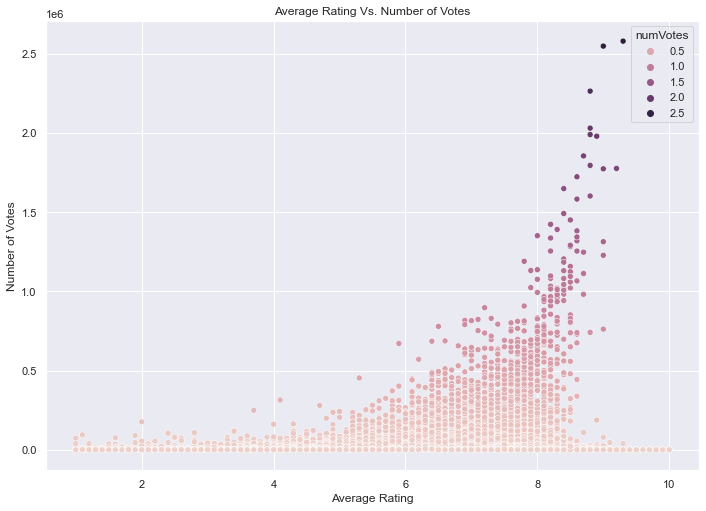

In [52]:
p = sns.scatterplot(data=merged_df, x="averageRating", y="numVotes", hue = 'numVotes')
p.set(xlabel = 'Average Rating', ylabel = 'Number of Votes', title= 'Average Rating Vs. Number of Votes')


Here was can see a pretty clear correlation, where it is more likely that a movie will have a good rating if there are more voters. Could this be due to "hype" surrounding a movie? Do people have a better experience of a movie if they know others think highly of it? Or are people that have a good experience more likely to vote? This would need further investigation.

## How does the runtime visualize against the release year?

[Text(0.5, 0, 'Release Year'),
 Text(0, 0.5, 'Runtime (Minutes)'),
 Text(0.5, 1.0, 'Runtime Vs. Release Year')]

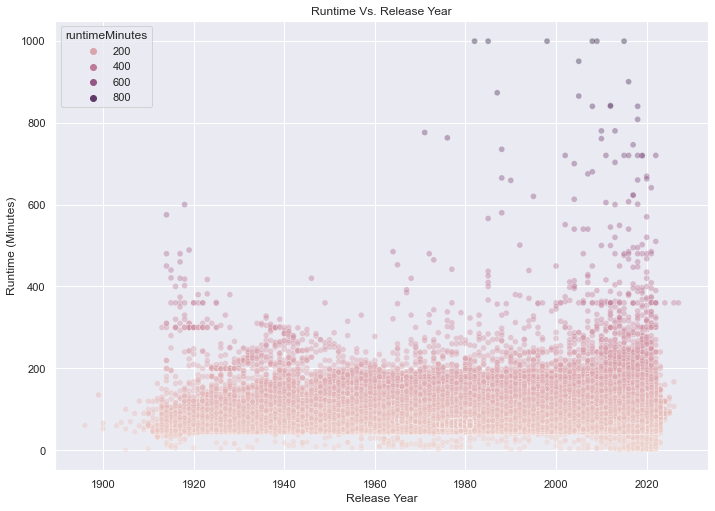

In [53]:
year_v_time = merged_df.loc[(merged_df['startYear'] != np.nan) & (merged_df['runtimeMinutes'] < 1000)]
p = sns.scatterplot(data= year_v_time, x="startYear", y="runtimeMinutes", alpha = 0.4, hue = 'runtimeMinutes')
p.set(xlabel = 'Release Year', ylabel = 'Runtime (Minutes)', title= 'Runtime Vs. Release Year')

There is only a `0.017` correlation between the two, but we can see that the longer movies have mostly occured in the last 40 years.

## How does the runtime visualize against the average rating?

[Text(0.5, 0, 'Runtime (Minutes)'),
 Text(0, 0.5, 'Average Rating'),
 Text(0.5, 1.0, 'Average Rating Vs. Runtime')]

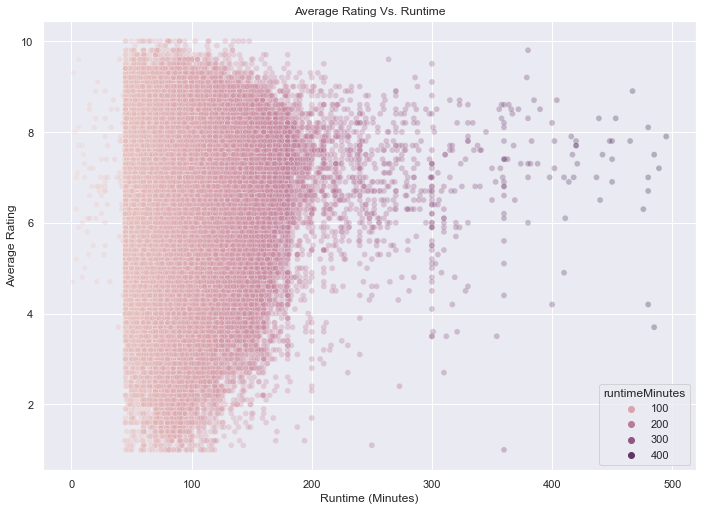

In [54]:
rating_v_time = merged_df.loc[(merged_df['runtimeMinutes'] < 500) & (merged_df['runtimeMinutes'] > 0) & (merged_df['startYear'] > 0)]
p = sns.scatterplot(data= rating_v_time, x="runtimeMinutes", y="averageRating", hue='runtimeMinutes', alpha = 0.3)
p.set(xlabel = 'Runtime (Minutes)', ylabel = 'Average Rating', title= 'Average Rating Vs. Runtime')

This correlation is even smaller at `0.0084`, but we can still see that much longer runtimes have a decent rating. However, if you were to produce a movie hoping for a high rating, there are more found in a normal runtime range.

## How has the popularity of certain genres changed over time?

We'll start by converting each genre cell into a list, so that we can use the Pandas `explode` function in order to create new rows with the year associated with each list. We'll filter out the movies with a `startYear` of NaN and those that have been announced for 2023 onward. I will also filter out `Drama`, `Documentary` and `Comedy`, since they show up in many of the entries and won't show as interesting a picture.

In [55]:
merged_df = merged_df.assign(genres=merged_df.genres.str.split(','))
genre_by_year = merged_df[['genres','startYear']].explode('genres')
genre_by_year = genre_by_year.loc[(genre_by_year['startYear'] != np.nan) & (genre_by_year['startYear'] < 2023)]
genre_by_year = genre_by_year.loc[~genre_by_year['genres'].isin(['Drama', 'Documentary', 'Comedy'])]
genre_by_year

,genres,startYear
0,NaN,1905.0
1,Action,1906.0
1,Adventure,1906.0
1,Biography,1906.0
6,Adventure,1908.0
...,...,...
608531,History,2020.0
608532,Adventure,2019.0
608532,History,2019.0
608532,War,2019.0


Here we groupby the year and genre in order to get a total count of that genre in that year.

In [56]:
genre_by_year_df = pd.DataFrame(genre_by_year.groupby(['startYear','genres']).genres.count())
genre_by_year_df.rename(columns = {'genres': 'genreCount'}, inplace=True)
genre_by_year_df = genre_by_year_df.reset_index()
genre_by_year_df

,startYear,genres,genreCount
0,1897.0,News,1
1,1897.0,Sport,1
2,1899.0,News,2
3,1899.0,Sport,3
4,1900.0,News,1
...,...,...,...
2271,2022.0,Sport,94
2272,2022.0,Talk-Show,6
2273,2022.0,Thriller,1299
2274,2022.0,War,61


In [61]:
fig = px.line(genre_by_year_df, x ='startYear', y = 'genreCount', color='genres')
fig.update_layout(title = 'Genre Popularity Vs. Release Year', xaxis_title = 'Release Year', yaxis_title='Genre Popularity',
legend_title = 'Genre Category')
fig.show()

We can see several interesting trends here. The `action` genre seems to spike from 1984 to 1990, whereas `romance` overtakes `crime` in 1991. There are many criss-crossing of genre popularity, and further investigation would help show the reasons. For instance, are `action` and `war` movies more popular in times of war, or in times of peace?

## How has the average rating changed over time?

In [58]:
vote_avg_year = merged_df.groupby(['startYear']).mean()
vote_avg_year = vote_avg_year.loc[(vote_avg_year['averageRating'] != np.nan) & (vote_avg_year.index > 0)]

In [59]:
fig = px.line(vote_avg_year, vote_avg_year.index, y='averageRating')
fig.update_layout(title = 'Average Rating Vs. Year', xaxis_title = 'Release Year', yaxis_title='Average Rating')
fig.show()

Keeping in mind that these ratings do not reflect the sentiment at the time of release, we see a pretty stable range between about `5.8` and `6.4`. There is a significant uptick in 2021, which could be attributed to many different reasons, but the high variance in older films makes sense as they are more niche.

# Summary

1. We downloaded the IMDb dataset from Kaggle.
2. We looked at the different files and chose relevant datasets.
3. We cleaned up the data by working with missing values.
4. We created visualizations for the number of movies produced over time.
5. We looked at the most popular genres of movies.
6. We looked at the most common runtimes of movies.
7. We looked at the relationship between the number of votes and the average rating.
8. We looked at the relationship between runtime and release year.
9. We looked at the relationship between runtime and average rating.
10. We looked at the change in genres over time.
11. We looked at the average rating given to titles over time.

## Ideas for future work

1. Are the times of 45 mins and 90 mins directly linked to whether they can be shown on TV and include ads?
2. Are Dramas so popular because most types of films can also be classified as Drama?
3. What was the reason the production of movies dropped from 1920-1924?
4. Why does the number of votes seem to correspond to a higher rating?
5. What are the reasons some genres have a spike or sudden decrease in popularity?

## References

[1] Pandas documentation. https://pandas.pydata.org/docs/  
[2] Aakash N S, Visualization with Matplotlib and Seaborn, 2021. https://jovian.ai/learn/zero-to-data-analyst-bootcamp/lesson/visualization-with-matplotlib-and-seaborn  
[3] Seaborn Scatterplot documentation. https://seaborn.pydata.org/examples/scatterplot_sizes.html  
[4] RealPython groupby guide. https://realpython.com/pandas-groupby/  
[5] Numerous stackoverflow pages.

In [63]:
jovian.commit(filename='imdbproject2')

<IPython.core.display.Javascript object>

[jovian] Updating notebook "freakflak/imdbproject2" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/freakflak/imdbproject2


'https://jovian.ai/freakflak/imdbproject2'